In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from datetime import datetime
import math
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import optuna

/var/folders/k_/ksvdlm8j31xfmslmhkz4xcj00000gq/T/ipykernel_38688/1124361891.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
/Users/uditg/anaconda3/envs/ocean/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tr_df = pd.read_csv('data/rents.csv', on_bad_lines='skip', sep=';', decimal=',', low_memory=False)
print(tr_df.shape)
tr_df.head()

(5475131, 22)


,Ejari Contract Number,Registration Date,Start Date,End Date,Property ID,Version,Area,Contract Amount,Annual Amount,Is Free Hold?,Property Size (sq.m),Property Type,Property Sub Type,Number of Rooms,Usage,Nearest Metro,Nearest Mall,Nearest Landmark,Parking,No of Units,Master Project,Project
0,120210425000238,25/04/2021 09:36:31,13/04/2021 00:00:00,12/04/2026 00:00:00,1058329686,New,Dubai Investment Park Second,25000.000,5000.000,Free Hold,7488.950,Building,Factory,NaN,Industrial,NaN,NaN,Expo 2020 Site,NaN,1,NaN,NaN
1,120210526001582,26/05/2021 12:12:22,01/06/2021 00:00:00,30/11/2025 00:00:00,99539298,New,Um Nahad Third,16000000.000,4000000.000,Free Hold,6792.000,Building,Building,NaN,Residential,NaN,NaN,NaN,NaN,1,NaN,NaN
2,120210526001913,26/05/2021 12:47:49,15/06/2021 00:00:00,14/12/2025 00:00:00,99539289,New,Um Nahad Third,16000000.000,4000000.000,Free Hold,6481.940,Building,Building,NaN,Residential,NaN,NaN,NaN,NaN,1,NaN,NaN
3,120210526002150,26/05/2021 13:14:55,01/07/2021 00:00:00,31/12/2025 00:00:00,99539307,New,Um Nahad Third,16000000.000,4000000.000,Free Hold,6792.000,Building,Building,NaN,Residential,NaN,NaN,NaN,NaN,1,NaN,NaN
4,120210526002235,26/05/2021 13:27:36,15/07/2021 00:00:00,14/01/2026 00:00:00,99539316,New,Um Nahad Third,16000000.000,4000000.000,Free Hold,6481.940,Building,Building,NaN,Residential,NaN,NaN,NaN,NaN,1,NaN,NaN


## Date Parse

In [3]:
tr_df.loc[:, 'Transaction Date'] = tr_df['Registration Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M:%S"))
tr_df.loc[:, 'Transaction Year'] = tr_df['Transaction Date'].apply(lambda x: x.year)

In [4]:
tr_df = tr_df.loc[lambda x: x['Transaction Year'] >= 2007]
tr_df = tr_df.loc[lambda x: (x['Annual Amount']>0) & (x['Property Size (sq.m)']>0)].copy()

In [ ]:
(~x['Property Size (sq.m)'].isna()) & (~x['Annual Amount'].isna())

## Build and Evaluate ML model efficacy

In [5]:
sorted(tr_df.columns)

['Annual Amount',
 'Area',
 'Contract Amount',
 'Ejari Contract Number',
 'End Date',
 'Is Free Hold?',
 'Master Project',
 'Nearest Landmark',
 'Nearest Mall',
 'Nearest Metro',
 'No of Units',
 'Number of Rooms',
 'Parking',
 'Project',
 'Property ID',
 'Property Size (sq.m)',
 'Property Sub Type',
 'Property Type',
 'Registration Date',
 'Start Date',
 'Transaction Date',
 'Transaction Year',
 'Usage',
 'Version']

In [6]:
tr_df.isna().sum()

Ejari Contract Number    0      
Registration Date        0      
Start Date               0      
End Date                 0      
Property ID              0      
Version                  0      
Area                     95     
Contract Amount          0      
Annual Amount            0      
Is Free Hold?            0      
Property Size (sq.m)     0      
Property Type            0      
Property Sub Type        39957  
Number of Rooms          5020799
Usage                    54677  
Nearest Metro            554708 
Nearest Mall             584715 
Nearest Landmark         338727 
Parking                  5050164
No of Units              0      
Master Project           5203930
Project                  4413970
Transaction Date         0      
Transaction Year         0      
dtype: int64

In [7]:
target_col = 'Annual Amount'
feature_cols = list(set(tr_df.columns) - set(['Annual Amount', 'Contract Amount', 'Ejari Contract Number',
                                              'Start Date', 'End Date', 'Transaction Year',
                                              'Property ID', 'Transaction Date', 'Registration Date']))

In [8]:
#Typecast 'oject' in pandas to categorical
for c in feature_cols:
    col_type = tr_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        tr_df[c] = tr_df[c].astype('category')

In [9]:
## Train-Test split
X_train, X_test, y_train, y_test = train_test_split(tr_df.loc[:, feature_cols], 
                                                    tr_df.loc[:, target_col], 
                                                    test_size=0.20, random_state=7)

In [11]:
##Find Best Hyperparameters using Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e1, log=True),
    }
    model = lgb.LGBMRegressor(random_state=7, n_jobs=-1, subsample=0.5)
    model.set_params(**params)
    cv_score = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
    return np.mean(cv_score)

optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2023-05-22 17:01:26,907] A new study created in memory with name: no-name-ef1c27d2-9d78-48f4-b950-ae934fe3f441
[I 2023-05-22 17:02:08,847] Trial 0 finished with value: 0.19296738180735182 and parameters: {'n_estimators': 220, 'learning_rate': 0.01835749297346225, 'max_depth': 3, 'colsample_bytree': 0.311363706037196, 'reg_lambda': 0.0024610571693088907}. Best is trial 0 with value: 0.19296738180735182.
[I 2023-05-22 17:02:54,577] Trial 1 finished with value: 0.531946196530531 and parameters: {'n_estimators': 220, 'learning_rate': 0.46303927138625584, 'max_depth': 4, 'colsample_bytree': 0.4728373444067927, 'reg_lambda': 2.547855999854814e-05}. Best is trial 1 with value: 0.531946196530531.
[I 2023-05-22 17:03:46,291] Trial 2 finished with value: 0.40564330630493045 and parameters: {'n_estimators': 230, 'learning_rate': 0.009549925637784295, 'max_depth': 5, 'colsample_bytree': 0.6425721468975866, 'reg_lambda': 0.0022578330181255196}. Best is trial 1 with value: 0.531946196530531.
[I 2

[I 2023-05-22 17:35:06,688] Trial 27 finished with value: 0.6189127552848259 and parameters: {'n_estimators': 500, 'learning_rate': 0.09446581001541147, 'max_depth': 6, 'colsample_bytree': 0.7065631693732932, 'reg_lambda': 8.588985837017614}. Best is trial 22 with value: 0.6369263390038612.
[I 2023-05-22 17:36:27,472] Trial 28 finished with value: 0.6198362601845766 and parameters: {'n_estimators': 410, 'learning_rate': 0.21178719109024796, 'max_depth': 5, 'colsample_bytree': 0.8759372241412671, 'reg_lambda': 0.2219182320940903}. Best is trial 22 with value: 0.6369263390038612.
[I 2023-05-22 17:38:38,929] Trial 29 finished with value: 0.46077862603268066 and parameters: {'n_estimators': 460, 'learning_rate': 0.01725051945089396, 'max_depth': 6, 'colsample_bytree': 0.38365600977889586, 'reg_lambda': 0.030893926978084716}. Best is trial 22 with value: 0.6369263390038612.


In [12]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

final_params = trial.params

Number of finished trials: 30
Best trial:
  Value: 0.6369263390038612
  Params: 
    n_estimators: 500
    learning_rate: 0.2459946236345984
    max_depth: 6
    colsample_bytree: 0.9301965456884775
    reg_lambda: 3.430672409458986


## Test Predictions of the Model

In [14]:
model = lgb.LGBMRegressor(random_state=7, n_jobs=-1, subsample=0.5)
model.set_params(**final_params)
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9301965456884775,
              learning_rate=0.2459946236345984, max_depth=6, n_estimators=500,
              random_state=7, reg_lambda=3.430672409458986, subsample=0.5)

In [15]:
test_df = X_test.copy()
test_df.loc[:, 'Actual Amount'] = y_test.copy()
test_df.loc[:, 'Predicted Amount'] = model.predict(X_test)
test_df.reset_index(drop=True, inplace=True)
test_df.loc[:, 'pct_diff'] = ((abs(test_df['Actual Amount'] - test_df['Predicted Amount']))/test_df['Actual Amount'])*100.0

In [16]:
pct_bins = list(np.arange(0, 101, 10)) + [test_df.pct_diff.max()+1]
pct_labels = ['<'+str(b) for b in pct_bins[1:]]
pct_labels[-1] = '<max'

test_df.loc[:, 'pct_diff_bin'] = pd.cut(test_df['pct_diff'], bins = pct_bins, 
                                        labels = pct_labels)

In [17]:
pct_diff_df = test_df['pct_diff_bin'].value_counts(normalize=True).sort_index().cumsum()
pct_diff_df

<10    0.237
<20    0.435
<30    0.588
<40    0.693
<50    0.764
<60    0.813
<70    0.847
<80    0.870
<90    0.888
<100   0.901
<max   1.000
Name: pct_diff_bin, dtype: float64

Text(0.5, 1.0, 'Fraction of Test cases predicted within a Tolerance Range')

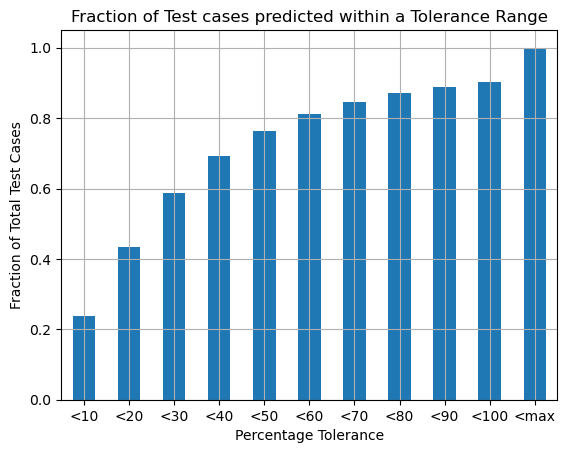

In [18]:
pct_diff_df.plot.bar()
plt.grid()
plt.xticks(rotation=0);
plt.ylabel('Fraction of Total Test Cases')
plt.xlabel('Percentage Tolerance')
plt.title('Fraction of Test cases predicted within a Tolerance Range')

In [19]:
#R2
r2_score(test_df['Actual Amount'], test_df['Predicted Amount'])

0.5842528960241106

## Analyze Importance of Factors over Time

In [20]:
test_years = list(range(2011, 2023))
test_years

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [21]:
def get_feature_importance_scores(test_year):
    #Assign Train, Test Df
    test_df = tr_df.loc[lambda x: x['Transaction Year'] == test_year].copy()
    train_df = tr_df.loc[lambda x: x['Transaction Year'] != test_year].copy()
    X_train = train_df.loc[:, feature_cols].copy()
    y_train = train_df.loc[:, target_col].copy()
    X_test = test_df.loc[:, feature_cols].copy()
    y_test = test_df.loc[:, target_col].copy()
    #Train Model
    model = lgb.LGBMRegressor(random_state=7, n_jobs=-1, subsample=0.5)
    model.set_params(**final_params)
    model.fit(X_train, y_train)
    #compute shap values
    shap_values = shap.TreeExplainer(model.booster_).shap_values(X_test)
    shap_df = pd.DataFrame(shap_values, columns = feature_cols)
    shap_series = (np.abs(shap_df)).mean(axis=0)
    return shap_series.to_frame(name=str(test_year)).T

In [22]:
shap_df_all = pd.DataFrame(columns=feature_cols)
for test_year in test_years:
    shap_df_local = get_feature_importance_scores(test_year)
    shap_df_all = pd.concat([shap_df_all, shap_df_local])

In [23]:
shap_df_all

,Usage,No of Units,Number of Rooms,Is Free Hold?,Area,Master Project,Property Type,Nearest Mall,Property Sub Type,Nearest Landmark,Property Size (sq.m),Parking,Project,Nearest Metro,Version
2011,11326.969,334522.427,416.236,1654.577,94863.168,0.000,5354.581,993.384,67262.689,4646.577,59615.962,2989.194,1358.097,25959.813,7429.204
2012,8793.210,433903.873,664.934,3055.067,125275.225,0.000,3771.119,6115.881,72012.395,4350.282,61372.345,2498.157,8543.896,46858.622,8968.100
2013,6261.406,395910.778,708.496,2635.309,102438.278,0.000,2136.441,2195.328,62097.658,5653.726,76934.137,1261.152,3590.468,40343.038,9161.444
2014,13684.314,433160.457,1140.247,6317.349,112598.277,0.000,5486.403,4831.531,74301.591,7305.091,68248.368,2753.085,7343.815,51133.098,11204.322
2015,11849.526,494158.349,954.081,4473.056,141359.425,0.000,3056.046,6452.194,80453.484,4263.015,83199.573,3680.954,7066.519,47989.887,15270.087
2016,16795.481,535540.299,990.948,4294.865,131920.961,0.000,3560.182,5975.465,59738.815,8097.583,87294.583,1298.685,8975.442,60435.920,13957.517
2017,15464.202,574378.906,1478.271,9851.805,132299.299,0.000,2072.740,7034.748,73586.305,11548.679,75766.211,2906.201,9826.189,66284.986,24447.338
2018,24370.678,611067.640,1754.153,6166.582,162768.130,0.000,4370.117,2400.200,95957.230,6207.036,87942.101,3166.164,12274.676,62810.403,17724.342
2019,15347.829,542798.723,1568.373,7281.869,133484.606,0.000,4681.338,4364.286,73255.835,6540.366,82346.792,1836.776,9848.573,57454.929,23935.389
2020,17356.377,599604.505,1852.233,6779.054,175438.278,0.000,2141.990,4132.312,83953.405,9660.597,84816.895,663.474,12510.554,53738.981,15393.895


Text(0.5, 1.0, 'Shap Importances')

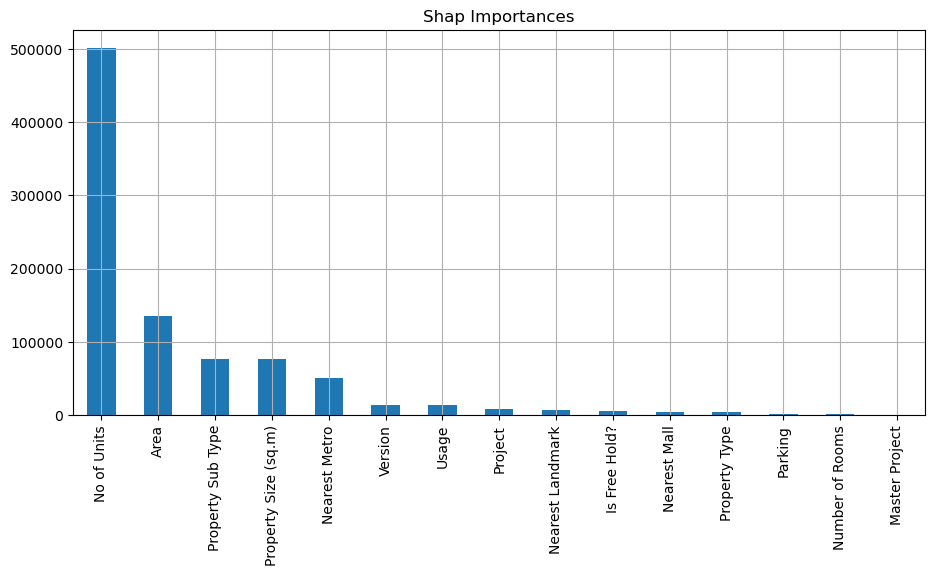

In [35]:
shap_df_all.mean(axis=0).sort_values(ascending=False).plot.bar(figsize=(11,5))
plt.grid()
plt.title('Shap Importances')

In [25]:
list_imp_features = shap_df_all.mean(axis=0).sort_values(ascending=False).index.to_list()

In [26]:
shap_df_ranked = shap_df_all.rank(axis=1)
shap_df_ranked

,Usage,No of Units,Number of Rooms,Is Free Hold?,Area,Master Project,Property Type,Nearest Mall,Property Sub Type,Nearest Landmark,Property Size (sq.m),Parking,Project,Nearest Metro,Version
2011,10.000,15.000,2.000,5.000,14.000,1.000,8.000,3.000,13.000,7.000,12.000,6.000,4.000,11.000,9.000
2012,9.000,15.000,2.000,4.000,14.000,1.000,5.000,7.000,13.000,6.000,12.000,3.000,8.000,11.000,10.000
2013,9.000,15.000,2.000,6.000,14.000,1.000,4.000,5.000,12.000,8.000,13.000,3.000,7.000,11.000,10.000
2014,10.000,15.000,2.000,6.000,14.000,1.000,5.000,4.000,13.000,7.000,12.000,3.000,8.000,11.000,9.000
2015,9.000,15.000,2.000,6.000,14.000,1.000,3.000,7.000,12.000,5.000,13.000,4.000,8.000,11.000,10.000
2016,10.000,15.000,2.000,5.000,14.000,1.000,4.000,6.000,11.000,7.000,13.000,3.000,8.000,12.000,9.000
2017,9.000,15.000,2.000,7.000,14.000,1.000,3.000,5.000,12.000,8.000,13.000,4.000,6.000,11.000,10.000
2018,10.000,15.000,2.000,6.000,14.000,1.000,5.000,3.000,13.000,7.000,12.000,4.000,8.000,11.000,9.000
2019,9.000,15.000,2.000,7.000,14.000,1.000,5.000,4.000,12.000,6.000,13.000,3.000,8.000,11.000,10.000
2020,10.000,15.000,3.000,6.000,14.000,1.000,4.000,5.000,12.000,7.000,13.000,2.000,8.000,11.000,9.000


## Save plots of Factor Importance ranks

In [33]:
from matplotlib.backends.backend_pdf import PdfPages
pdf_session = PdfPages('importance_rank_rentals.pdf')

In [34]:
for f in list_imp_features:
    plt.figure()
    shap_df_ranked[f].plot.bar()
    plt.title(f)
    plt.grid()
    plt.ylim(1, 15)
    plt.ylabel('Rank (higher is better)')
    pdf_session.savefig()
    plt.close()
pdf_session.close()